<a href="https://colab.research.google.com/github/matthewpecsok/4482_fall_2022/blob/main/tutorials/4482_Naive_Bayes-Titanic-Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NB Titaic Tutorial
Converted to Python by Matthew Pecsok from Dr. Olivia Sheng's original tutorial in R
June 12, 2021

1 Data description

2 Library Setup

3 Overall data inspection

4 NB model building using sklearn package

5 Explanatory data exploration

6 Generate performance metrics

7 Simple hold-out evaluation


# 1 Data description

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people such as women, children, and the upper-class were more likely to survive than others.

VARIABLE DESCRIPTIONS:

PassengerID Unique passenger identifier

Survived Survival (0 = No; 1 = Yes)

Pclass Passenger Class(1 = 1st; 2 = 2nd; 3 = 3rd) (Pclass is a proxy for socio-economic status (SES) 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower)

Name

Sex

Age - (Age is in Years; Fractional if Age less than One (1) If the Age is Estimated, it is in the form xx.5)

Sibsp - Number of Siblings/Spouses Aboard Parch Number of Parents/Children Aboard

Ticket Number

Fare - Passenger Fare

Cabin

Embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)


# 2 Library Setup

https://scikit-learn.org/stable/modules/naive_bayes.html

In [1]:
import pandas as pd
import numpy as np

import os

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import GaussianNB

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn import metrics


# 3 overall data inspection

In [2]:
titanic = pd.read_csv("https://raw.githubusercontent.com/matthewpecsok/4482_fall_2022/main/data/titanic_cleaned.csv")
titanic_orig = titanic.copy()

In [3]:
type(titanic)

pandas.core.frame.DataFrame

https://scikit-learn.org/stable/modules/generated/sklearn.utils.Bunch.html

In [4]:
titanic.shape

(714, 9)

In [5]:
titanic.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin',
       'Embarked'],
      dtype='object')

tranform the data from a numpy array and a list into a pandas dataframe for exploratory data analyisi

In [6]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  714 non-null    int64  
 1   Pclass    714 non-null    int64  
 2   Sex       714 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     714 non-null    int64  
 5   Parch     714 non-null    int64  
 6   Fare      714 non-null    float64
 7   Cabin     714 non-null    object 
 8   Embarked  714 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 50.3+ KB


In [7]:
# remove all non-categorical type columns
# also remove cabin as it is causing issues currently when splitting
titanic = titanic[['Survived','Sex','Embarked','Pclass']]

In [8]:
titanic

,Survived,Sex,Embarked,Pclass
0,0,male,S,3
1,1,female,C,1
2,1,female,S,3
3,1,female,S,1
4,0,male,S,3
...,...,...,...,...
709,0,female,Q,3
710,0,male,S,2
711,1,female,S,1
712,1,male,C,1


In [9]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Survived  714 non-null    int64 
 1   Sex       714 non-null    object
 2   Embarked  714 non-null    object
 3   Pclass    714 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 22.4+ KB


In [10]:
titanic.describe(include='all')

,Survived,Sex,Embarked,Pclass
count,714.000000,714,714,714.000000
unique,NaN,2,4,NaN
top,NaN,male,S,NaN
freq,NaN,453,554,NaN
mean,0.406162,NaN,NaN,2.236695
std,0.491460,NaN,NaN,0.838250
min,0.000000,NaN,NaN,1.000000
25%,0.000000,NaN,NaN,1.000000
50%,0.000000,NaN,NaN,2.000000
75%,1.000000,NaN,NaN,3.000000


In [11]:
titanic.head(2)

,Survived,Sex,Embarked,Pclass
0,0,male,S,3
1,1,female,C,1


## 3.1 Data Type Update Notes

One key change this notebook has that needs to be addressed which was not explained in the video is the fact that we are using a single Categorical model here for Naive Bayes. The sklearn package doesn't support using a single model for both Gaussian (continuous ie 1.3,2.5,1.98 etc) data as well as categorical data such as A,B,C. This means that two models need to be fit in order to achieve the same predictions as the R package e1071 which can handle multiple variable types. At the root of this is the fact that in R factor variables are intended to be created in the data transformation phase, and then the model itself can use this information to use a gaussian model for continuous data and categorical model for categorical data. In python we do not code factor data in quite the same way and so the models do not support this outof the box. 

To resolve this issue we predict with both models on their respective data and then do a tiny bit of math using what we know about bayes formula to get back to a single classification prediction. 

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html


In [12]:
y = titanic.pop('Survived')

## Dummy encoding the dataframe 

## 3.2 encode the data 

In [13]:
#convert all columns to 
titanic['Pclass'] = titanic['Pclass'].astype(str)
titanic.dtypes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Sex         object
Embarked    object
Pclass      object
dtype: object

In [14]:
titanic_enc = pd.get_dummies(titanic)

In [15]:
titanic_enc.dtypes

Sex_female          uint8
Sex_male            uint8
Embarked_C          uint8
Embarked_Q          uint8
Embarked_S          uint8
Embarked_missing    uint8
Pclass_1            uint8
Pclass_2            uint8
Pclass_3            uint8
dtype: object

## 3.5 build a new predictive model with ONLY  categorical features, return the predictions


In [16]:
cnb = CategoricalNB() # create a gaussian model

cnb.fit(titanic_enc,y)
cnb_pred_proba = cnb.predict_proba(titanic_enc) # predict and get probabilities value

cnb_pred_proba[0:10]

array([[0.98069682, 0.01930318],
       [0.00367487, 0.99632513],
       [0.27072797, 0.72927203],
       [0.02145873, 0.97854127],
       [0.98069682, 0.01930318],
       [0.75007169, 0.24992831],
       [0.98069682, 0.01930318],
       [0.27072797, 0.72927203],
       [0.00992887, 0.99007113],
       [0.27072797, 0.72927203]])

# 4 NB model building using sklearn package

In [17]:
cnb_pred = cnb.predict(titanic_enc) # predict and get probabilities value

cnb_pred[0:10]

array([0, 1, 1, 1, 0, 0, 0, 1, 1, 1])

In [18]:
print(cnb.class_prior)

None


# 5 Explanatory data exploration

In [19]:
pd.crosstab(titanic_orig['Survived'], titanic_orig['Sex'])

Sex,female,male
Survived,,
0,64,360
1,197,93


In [20]:
# overall proportions
pd.crosstab(titanic_orig['Sex'], titanic_orig['Survived'])/titanic_orig.shape[0]


Survived,0,1
Sex,,
female,0.089636,0.275910
male,0.504202,0.130252


In [21]:
# proportions by gender
ct = pd.crosstab(titanic_orig['Sex'], titanic_orig['Survived'])
ct.div(ct.sum(axis=0), axis=1)

Survived,0,1
Sex,,
female,0.150943,0.67931
male,0.849057,0.32069


In [23]:
# proportions by gender
ct = pd.crosstab(titanic_orig['Sex'], titanic_orig['Survived'])
ct.div(ct.sum(axis=1), axis=0)

Survived,0,1
Sex,,
female,0.245211,0.754789
male,0.794702,0.205298


In [24]:
# proportions by Embarked
ct = pd.crosstab(titanic_orig['Embarked'], titanic_orig['Survived'])
ct.div(ct.sum(axis=0), axis=1)

Survived,0,1
Embarked,,
C,0.120283,0.272414
Q,0.047170,0.027586
S,0.832547,0.693103
missing,0.000000,0.006897


In [25]:
# proportions by Pclass
ct = pd.crosstab(titanic_orig['Pclass'], titanic_orig['Survived'])
ct.div(ct.sum(axis=0), axis=1)

Survived,0,1
Pclass,,
1,0.150943,0.420690
2,0.212264,0.286207
3,0.636792,0.293103


In [26]:
# proportions by Pclass
ct = pd.crosstab(titanic_orig['Pclass'], titanic_orig['Survived'])
ct.div(ct.sum(axis=1), axis=0)

Survived,0,1
Pclass,,
1,0.344086,0.655914
2,0.520231,0.479769
3,0.760563,0.239437


# 5 Generate performance metrics

In [27]:
from sklearn.metrics import plot_confusion_matrix

In [28]:
# use the predictions we made a little bit ago to create a confusion matrix
cm = confusion_matrix(y,cnb_pred,labels=[0,1])
print(cm)

[[340  84]
 [ 77 213]]


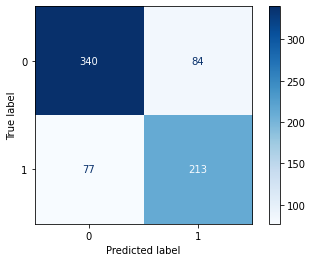

In [29]:
# show a confusion matrix in a more legible format

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=cnb.classes_
                              )
disp.plot(values_format='',cmap=plt.cm.Blues)
plt.show()


In [31]:
print(metrics.classification_report(y,cnb_pred))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81       424
           1       0.72      0.73      0.73       290

    accuracy                           0.77       714
   macro avg       0.77      0.77      0.77       714
weighted avg       0.78      0.77      0.77       714



It's worth noting here that we used the stratify=target argument to the split function to make sure that each target class is represented at the same proportion in the test and train set. sklearn does NOT do this by default, while in R createdatapartition does. 

# 6 Simple hold-out evaluation

In [32]:
cnb_split_model = CategoricalNB(alpha=0)

In [33]:
titanic_pre_train_test_split = titanic.copy()
#titanic_pre_train_test_split = titanic[['Survived','Sex','Pclass','Embarked']]
titanic_pre_train_test_split_enc = pd.get_dummies(titanic_pre_train_test_split)
titanic_pre_train_test_split_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Sex_female        714 non-null    uint8
 1   Sex_male          714 non-null    uint8
 2   Embarked_C        714 non-null    uint8
 3   Embarked_Q        714 non-null    uint8
 4   Embarked_S        714 non-null    uint8
 5   Embarked_missing  714 non-null    uint8
 6   Pclass_1          714 non-null    uint8
 7   Pclass_2          714 non-null    uint8
 8   Pclass_3          714 non-null    uint8
dtypes: uint8(9)
memory usage: 6.4 KB


In [35]:
# now that we have encoded our data split it into train test
X = titanic_pre_train_test_split_enc
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.3, random_state=0,stratify=y)

In [36]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(499, 9)
(215, 9)
(499,)
(215,)


In [37]:
y_train.value_counts()

0    296
1    203
Name: Survived, dtype: int64

In [38]:
y_train.value_counts()/len(y_train)

0    0.593186
1    0.406814
Name: Survived, dtype: float64

In [39]:
y_test.value_counts()

0    128
1     87
Name: Survived, dtype: int64

In [40]:
y_test.value_counts()/len(y_test)

0    0.595349
1    0.404651
Name: Survived, dtype: float64

In [41]:
# FIT the model
cnb_split_model.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN


CategoricalNB(alpha=0)

In [42]:
# predict on the TRAIN data
y_pred_train = cnb_split_model.predict(X_train)

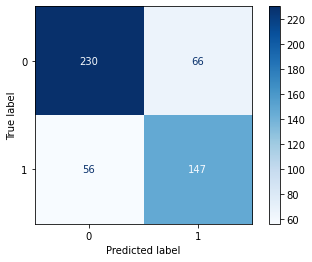

In [43]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_train,y_pred_train),
    display_labels=cnb_split_model.classes_
    )
disp.plot(values_format='',cmap=plt.cm.Blues)
plt.show()

In [44]:
print(metrics.classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79       296
           1       0.69      0.72      0.71       203

    accuracy                           0.76       499
   macro avg       0.75      0.75      0.75       499
weighted avg       0.76      0.76      0.76       499



In [45]:
# now predict on our hold out data. this dataset is intended to replicate the "real" world by including data
# that the model did not get to see when being fitted. it is simply a subset of our original data
# predict on the TEST data
import numpy as np

y_pred_test = cnb_split_model.predict(X_test)

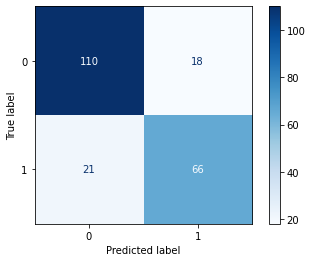

In [46]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test,y_pred_test),
    display_labels=cnb_split_model.classes_
    )
disp.plot(values_format='',cmap=plt.cm.Blues)
plt.show()

In [47]:
print(metrics.classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       128
           1       0.79      0.76      0.77        87

    accuracy                           0.82       215
   macro avg       0.81      0.81      0.81       215
weighted avg       0.82      0.82      0.82       215



In [48]:
!cp "/content/drive/My Drive/Colab Notebooks/4482_Naive_Bayes-Titanic-Tutorial.ipynb" ./

# run the second shell command, jupyter nbconvert --to html "file name of the notebook"
# create html from ipynb

!jupyter nbconvert --to html "4482_Naive_Bayes-Titanic-Tutorial.ipynb"

cp: cannot stat '/content/drive/My Drive/Colab Notebooks/4482_Naive_Bayes-Titanic-Tutorial.ipynb': No such file or directory
[NbConvertApp] WARNING | pattern '4482_Naive_Bayes-Titanic-Tutorial.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--Jupyte